# Localisation

## Let's talk Bayes

### Let's look at a robotic example:

In [ ]:
"""
Demonstrate Bayes Theorem with 1D localization example

A robot is moving in a 1D world. It has a sensor that can measure the distance
to a landmark. The robot can also move in the world. The robot has a belief
about its position in the world. The belief is represented by a probability
distribution over the world. The robot can update its belief based on the
sensor measurement and its motion.

In this example the robot is moving in one direction in a uniform way.
Both the sensor and the motion are noisy.
"""
import numpy as np
import matplotlib.pyplot as plt

# Set up the problem
# 1D world
world_size = 100
# samples
N = 20
# 1D measurements
measurements = np.linspace(0, world_size-1, N)
# add noise to measurements
measurements += np.random.randint(-1, 1, len(measurements))
# set measurements to integers
measurements = measurements.astype(int)
# 1D motion
motion = world_size // N * np.ones(len(measurements))
# add noise to motion
motion += np.random.randint(-1, 1, len(motion))
motion = motion.astype(int)
# Probability of correct measurement
pHit = 0.6
# Probability of incorrect measurement
pMiss = 0.2
# Probability of correct motion
pExact = 0.8
# Probability of undershooting
pUndershoot = 0.1
# Probability of overshooting
pOvershoot = 0.1

# Initialize the belief
belief = np.ones(world_size) / world_size

# Plot the initial belief with true position
plt.figure()
plt.plot(belief)
plt.title('Initial Belief')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.axvline(x=measurements[0], color='r', linestyle='--')
plt.legend(['Initial Belief', 'True Position'])
plt.show(block=False)

# Iterate through the measurements and motions
for i in range(len(measurements)):
    # Measurement update
    # Compute the likelihood of the measurement
    likelihood = np.ones(world_size)
    for j in range(world_size):
        if j == measurements[i]:
            likelihood[j] *= pHit
        else:
            likelihood[j] *= pMiss
    # Compute the posterior belief
    belief = belief * likelihood
    belief /= np.sum(belief)
    # Plot the posterior belief with the true position
    plt.figure()
    plt.plot(belief)
    plt.title('Posterior Belief')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.axvline(x=measurements[i], color='r', linestyle='--')
    plt.legend(['Belief', 'True Position'])
    plt.show(block=False)
    # Motion update
    # Compute the prior belief
    prior = np.zeros(world_size)
    for k in range(world_size):
        prior[k] = pExact * belief[(k - motion[i]) % world_size]
        prior[k] += pUndershoot * belief[(k - motion[i] - 1) % world_size]
        prior[k] += pOvershoot * belief[(k - motion[i] + 1) % world_size]
    # Update the belief
    belief = prior
    # # Plot the prior belief
    # plt.figure()
    # plt.plot(belief)
    # plt.title('Prior Belief')
    # plt.xlabel('Position')
    # plt.ylabel('Probability')
    # plt.show(block=False)

# Localisation with a Map

## Adaptive Monte-Carlo Localisation (AMCL)

### Let's look at a particle filter example:

#### First we create a map to localise in

In [ ]:
"""
An example of a 2d localisation particle filter

A robot is moving in a 2D world. It has a sensor that can measure the distance
to a landmark. The robot can also move in the world. The robot has a belief
about its position in the world. The belief is represented by a probability
distribution over the world. The robot can update its belief based on the
sensor measurement and its motion.

The world is sampled as particles. Each particle has a position and a weight.
The weight is the probability of the particle being in the correct position.
The particles are updated based on the sensor measurement and the motion.
"""


import numpy as np
import matplotlib.pyplot as plt


# create a 2d world
world_size = 50
world = np.zeros((world_size, world_size))
# randomise the landmark starting positions
num_landmarks = 4
landmarks = np.random.randint(0, world_size, (num_landmarks, 2))
# add landmarks
world[landmarks[:, 0], landmarks[:, 1]] = 1
# grow the landmarks
for i in range(3):
    world = np.logical_or(world, np.roll(world, 1, axis=0))
    world = np.logical_or(world, np.roll(world, 1, axis=1))

# place the robot in the world as a RED dot
robot = np.random.randint(0, world_size, 2)

# show the world map with inverse colors
plt.figure()
plt.imshow(1 - world, cmap='gray')
plt.scatter(robot[1], robot[0], color='r')
plt.title('World Map')
plt.show(block=False)

#### Let's create some location samples

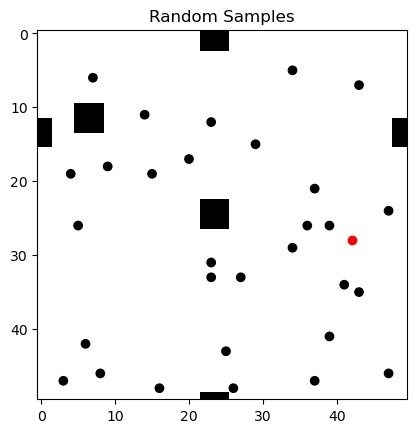

In [5]:
"""
An example of a 2d localisation particle filter

Creating the particles
"""


import numpy as np
import matplotlib.pyplot as plt


# create random 2D samples
num_samples = 30
samples = np.random.randint(0, world_size, (num_samples, 2))

# resample any samples that are on a landmark
for i in range(num_samples):
    while world[samples[i, 0], samples[i, 1]] == 1:
        samples[i] = np.random.randint(0, world_size, 2)

# create equal weights
weights = np.ones(num_samples) / num_samples

# plot the samples
plt.figure()
plt.imshow(1 - world, cmap='gray')
plt.scatter(samples[:, 1], samples[:, 0], c=weights, cmap='gray')
plt.scatter(robot[1], robot[0], color='r')
plt.title('Random Samples')
plt.show(block=False)

#### Iteratively update the samples

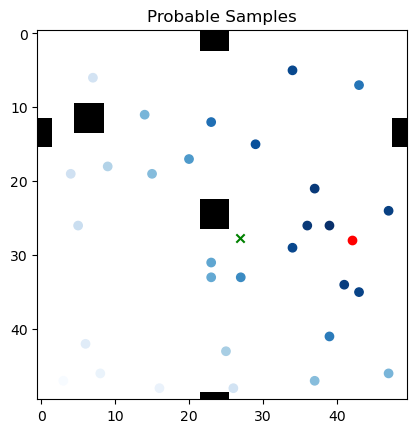

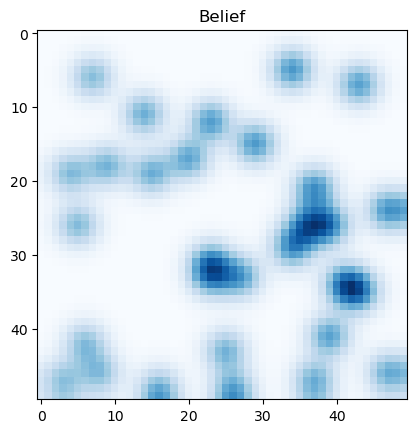

C:\Users\James\AppData\Local\Temp\ipykernel_28804\3694308602.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_weights[i] = np.random.choice(belief.flatten(), 1, p=belief.flatten())


In [6]:
"""
An example of a 2d localisation particle filter

Update the particles based on the sensor measurement
"""


import numpy as np
import matplotlib.pyplot as plt


# make a measurement of the landmarks for the robot
# this will be the true distance to the nearest landmark
measurement = np.zeros(num_landmarks)
for i in range(num_landmarks):
    # compute the distance to each landmark
    measurement[i] = np.linalg.norm(landmarks[i] - robot)

# create a gaussian probability model for the measurement error
# the probability of the measurement given the true distance to the landmark
def sample_probability(sample, true_distance):
    """
    Compute the probability of the sample measurement given the true distance to the landmark
    """
    # compute the probability of the measurement given the true distance to the landmark
    probability = np.zeros(num_landmarks)
    for i in range(num_landmarks):
        # the sample measurement distance to the landmark
        sample_distance = np.linalg.norm(landmarks[i] - sample)

        # what is the likelyhood of the sample measurement given the true distance to the landmark
        # this is the probability of the measurement given the true distance
        probability[i] = 1 / np.sqrt(2 * np.pi * np.square(true_distance[i]))
        probability[i] *= np.exp(-np.square(sample_distance - true_distance[i]) / (2 * np.square(true_distance[i])))

    return np.sum(probability)

# make a measurement of the nearest landmarks to each sample
# compute the weights based on the likelihood of the measurement given the robot measurements
for i in range(num_samples):
    weights[i] = sample_probability(samples[i], measurement)

# normalise the weights
weights /= np.sum(weights)

# find the centroid of the weighted samples
# this is the estimated robot position
robot_estimate = np.average(samples, axis=0, weights=weights)

# create a 2d probability distribution of the samples
# this is the belief
belief = np.zeros((world_size, world_size))
for i in range(num_samples):
    belief[samples[i, 0], samples[i, 1]] += weights[i]

# smooth the 2d belief with gaussian blur
from scipy.ndimage import gaussian_filter
belief = gaussian_filter(belief, sigma=2)
# normalise the belief
belief /= np.sum(belief)

# plot the samples and the belief distribution as subplots
plt.figure()
plt.imshow(1 - world, cmap='gray')
plt.scatter(robot[1], robot[0], color='r')
# plot the samples in blue with weighted colour
plt.scatter(samples[:, 1], samples[:, 0], c=weights, cmap='Blues')
plt.scatter(robot_estimate[1], robot_estimate[0], color='g', marker='x')
plt.title('Probable Samples')
plt.show(block=False)

plt.figure()
plt.imshow(belief, cmap='Blues')
plt.title('Belief')
plt.show(block=False)

# sample 30 new 2D particles based on the belief
# the new samples will be selected based on weight of the belief
new_samples = np.zeros((num_samples, 2)).astype(int)
new_weights = np.zeros(num_samples)
for i in range(num_samples):
    # sample a new particle (x, y) from the belief
    new_weights[i] = np.random.choice(belief.flatten(), 1, p=belief.flatten())
    # get the indexes of the sampled weight
    index = np.where(belief == new_weights[i])
    # if there are multiple indexes, choose one at random
    if len(index[0]) > 1:
        index = np.random.choice(len(index[0]), 1)

    # get the x, y position of the sampled weight as integers
    new_samples[i] = np.array(index).T

    # resample any samples that are on a landmark
    while world[new_samples[i, 0], new_samples[i, 1]] == 1:
        new_samples[i] = np.random.randint(0, world_size, 2)

# move the robot and repeat the process for the next measurement
robot += np.random.randint(-2, 5, 2)
samples = new_samples